# Demo : plaintext full method tests

In [226]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.abspath('..'))
from src.config import setup_logging
logger = setup_logging("DEBUG")

from src.data.data_utils import load_data, num_to_data_path, train_test_split, stack_and_scale
from src.data.preprocessing import bin_to_pm1, add_bias, init_wv, pad_to_pow2_cols, pad_to_pow2_rows
from src.data.scalers import MaxAbsScaler, MinMaxScaler, StandardScaler

from src.sigmoid import get_sigmoid_approx
from src.nag_momentum import NAGUpdater

from src.models.logreg_pt import LogisticRegressionPt
from src.metrics import print_classification_metrics, calculate_acc_auc_idash_style, beta_to_loss_history, plot_loss_evolution, plot_proba_distrib


In [227]:
# Parameters
dataset_num = 6

n_epoch = 7
gamma_up = 10
gamma_down = -1

use_nag = True
scaler = MaxAbsScaler()     # MaxAbsScaler(), MinMaxScaler(), StandardScaler()
beta_init_method = "mean-idash"   # mean, zero, random
nag_smooth_method = NAGUpdater('idash')

degree = 5  # 3, 5, 7
true_sigmoid = get_sigmoid_approx()
minus_sigmoid = get_sigmoid_approx("minus_sigmoid")
sigmoid = get_sigmoid_approx("least_squares", degree=degree)

DEBUG - Getting sigmoid approximation: method=sigmoid, degree=0, encrypted=False
DEBUG - Getting sigmoid approximation: method=minus_sigmoid, degree=0, encrypted=False
DEBUG - Getting sigmoid approximation: method=least_squares, degree=5, encrypted=False


## Load data and preprocessing

In [228]:
X, y_bin = load_data(num_to_data_path(dataset_num))

INFO - Loading data from ../data/uis.txt
INFO - Loaded dataset with 575 samples and 8 features


In [229]:
# iDASH
X_train, X_test, y_bin_train, y_bin_test = train_test_split(X, y_bin, test_size=0.2)

Z_train_ = bin_to_pm1(y_bin_train)[:, np.newaxis] * add_bias(X_train)
Z_test_ = bin_to_pm1(y_bin_test)[:, np.newaxis] * add_bias(X_test)

Z_train, Z_test = stack_and_scale(scaler, Z_train_, Z_test_)

w, v = init_wv(Z_train, method=beta_init_method)

INFO - Splitting data into train/test sets
DEBUG - Train size: 460, Test size: 115
INFO - Adding bias term
DEBUG - Added bias term: (460, 8) -> (460, 9)
INFO - Adding bias term
DEBUG - Added bias term: (115, 8) -> (115, 9)
INFO - Stacking and scaling data
DEBUG - Scaled rang: [-1.0, 1.0]
INFO - Initializing weights for 9 features as: 'mean-idash'
DEBUG - Weight stats - Min: 0.0001, Max: 0.0009, Mean: 0.0005


In [230]:
# # iDASH corrected
# X_ = add_bias(X)

# X_train, X_test, y_bin_train, y_bin_test = train_test_split(X_, y_bin, test_size=0.2)

# Z_train = scaler.fit_transform(X_train)
# Z_test = scaler.transform(X_test)

# Z_train = bin_to_pm1(y_bin_train)[:, np.newaxis] * Z_train

# w, v = init_wv(Z_train, method=beta_init_method)

In [231]:
# Encode
Z_train_padded = pad_to_pow2_rows(pad_to_pow2_cols(Z_train))
Z_test_padded = pad_to_pow2_cols(Z_test)
# y_train = pad_to_pow2_rows(y_train[:, np.newaxis])[:, 0]

n, f_plus_1 = Z_train_padded.shape
f = f_plus_1 - 1
Z_dims = (n, f)

w_padded = pad_to_pow2_cols(w.reshape(1, -1))
w_padded = np.tile(w_padded, (Z_dims[0], 1))
v_padded = pad_to_pow2_cols(v.reshape(1, -1))
v_padded = np.tile(v_padded, (Z_dims[0], 1))

INFO - Padding columns: 9 -> 16 (next power of 2)
INFO - Padding rows: 460 -> 512 (next power of 2)
INFO - Padding columns: 9 -> 16 (next power of 2)
INFO - Padding columns: 9 -> 16 (next power of 2)
INFO - Padding columns: 9 -> 16 (next power of 2)


## Logistic regression

In [232]:

model_no_nag = LogisticRegressionPt(
    sigmoid=sigmoid,
    use_NAG=use_nag,
    nag_momentum_update=nag_smooth_method
)
model_no_nag.fit(
    Z_train_padded, Z_dims,
    w_padded,
    n_epoch=n_epoch,
    gamma_up=gamma_up,
    gamma_down=gamma_down,
    pt_v=v_padded
)

INFO - >>> Epoch 1 <<<
DEBUG - Learning rate: 5.0000 - Smoothing parameter: 0.0
DEBUG - Computing inner product
DEBUG - Mask created: length 512
INFO - Inner product computed.
DEBUG - lsq input: [-0.0037, 0.0037]
DEBUG - lsq approx: [0.4993, 0.5007]
DEBUG - Computing aggregate gradient
INFO - Aggregate gradient computed.
INFO - >>> Epoch 2 <<<
DEBUG - Learning rate: 3.3333 - Smoothing parameter: -0.28175352512532087
DEBUG - Computing inner product
DEBUG - Mask created: length 512
INFO - Inner product computed.
DEBUG - lsq input: [-4.2401, 4.2807]
DEBUG - lsq approx: [-0.0177, 1.0173]
DEBUG - Computing aggregate gradient
INFO - Aggregate gradient computed.
INFO - >>> Epoch 3 <<<
DEBUG - Learning rate: 2.5000 - Smoothing parameter: -0.434042782780302
DEBUG - Computing inner product
DEBUG - Mask created: length 512
INFO - Inner product computed.
DEBUG - lsq input: [-0.9252, 0.9432]
DEBUG - lsq approx: [0.3234, 0.6734]
DEBUG - Computing aggregate gradient
INFO - Aggregate gradient computed

## Analysis

### Train

In [233]:
# Decode
original_samples, original_features = add_bias(X_train).shape
beta_history_depadded = np.array([beta[0][:original_features] for beta in model_no_nag.beta_history])

INFO - Adding bias term
DEBUG - Added bias term: (460, 8) -> (460, 9)


DEBUG - lsq input: [-0.0037, 0.0037]
DEBUG - lsq approx: [0.4993, 0.5007]
DEBUG - lsq input: [-4.2401, 4.2807]
DEBUG - lsq approx: [-0.0177, 1.0173]
DEBUG - lsq input: [-1.6250, 1.6425]
DEBUG - lsq approx: [0.2057, 0.7916]
DEBUG - lsq input: [-1.9455, 1.9671]
DEBUG - lsq approx: [0.1574, 0.8395]
DEBUG - lsq input: [-1.8378, 1.8651]
DEBUG - lsq approx: [0.1721, 0.8239]
DEBUG - lsq input: [-1.8162, 1.8598]
DEBUG - lsq approx: [0.1729, 0.8207]
DEBUG - lsq input: [-1.8314, 1.8916]
DEBUG - lsq approx: [0.1682, 0.8230]
DEBUG - lsq input: [-1.8527, 1.9300]
DEBUG - lsq approx: [0.1627, 0.8261]


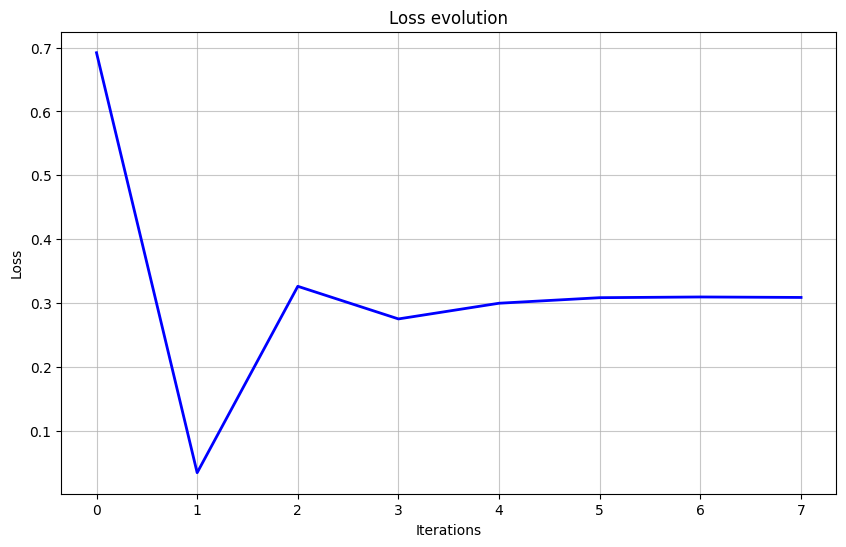

In [234]:
beta_history = np.concatenate([[w], beta_history_depadded])
loss_history = beta_to_loss_history(beta_history, Z_train, y_bin_train, sigmoid)
plot_loss_evolution(loss_history)

### Test

In [235]:
w_trained = model_no_nag.pt_beta[0][:original_features]
proba = model_no_nag.predict_proba(Z_test, w_trained, sigmoid=sigmoid)
print_classification_metrics(
    y_bin_test, proba
)

DEBUG - lsq input: [-1.8100, 1.8937]
DEBUG - lsq approx: [0.1679, 0.8198]



ACC: 1.0000
AUC: 1.0000
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        28
         1.0       1.00      1.00      1.00        87

    accuracy                           1.00       115
   macro avg       1.00      1.00      1.00       115
weighted avg       1.00      1.00      1.00       115

[[28  0]
 [ 0 87]]

MSE: 0.0000
NMSE: 0.0000



(np.float64(1.0), 1.0)

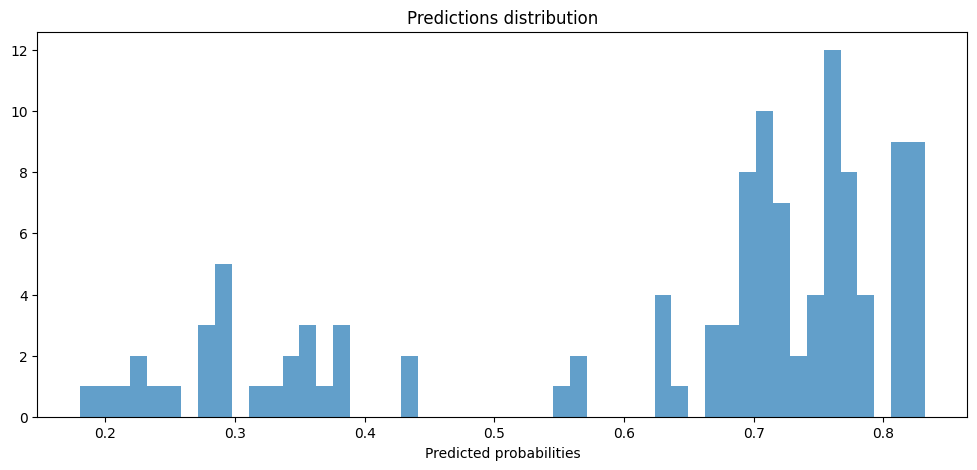

In [236]:
plot_proba_distrib(proba)

In [237]:
calculate_acc_auc_idash_style(Z_test, w_trained)

ACC: 75.6522 %.
AUC: 0.6925


(75.65217391304347, 0.6925287356321839)